## Imports

In [2]:
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

## definitions

In [3]:
np.random.seed(42)
NUM_FEATURE = 12
RANDOM_DATA = True

In [4]:
def get_data(red=False):
    #get red wine data  
    red_data = np.genfromtxt('../data/winequality-red.csv',delimiter=';')
    red_data = np.delete(red_data,(0),axis=0)
    red_feature = np.array([[1 for i in range(red_data.shape[0])]])
    red_y = np.array([red_data[:,11]])
    red_data = np.append(red_data[:,0:11],red_feature.T,axis=1)
    red_data = np.append(red_data,red_y.T,axis=1)
    print
    if red:
        return red_data
        #get white wine data
    white_data = np.genfromtxt('../data/winequality-white.csv',delimiter=';')
    white_data = np.delete(white_data,(0),axis=0)
    white_feature = np.array([[-1 for i in range(white_data.shape[0])]])
    white_y = np.array([white_data[:,11]])
    white_data = np.append(white_data[:,0:11],white_feature.T,axis=1)
    white_data = np.append(white_data,white_y.T,axis=1)
    #combine the 2
    data = np.append(red_data,white_data,axis=0)
    if RANDOM_DATA:
        np.random.shuffle(data)
    return data

## Data Split
split 80% training, 20% test Normalised using training data

In [5]:
def split_data(data,train_split=0.8):
    #train,test,val
    train,test = np.split(data, [int(train_split*data.shape[0])])

    train_x,train_y = np.hsplit(train,[NUM_FEATURE])
    test_x,test_y   = np.hsplit(test, [NUM_FEATURE])
    
    #remove outliers
    '''
    #normalise data
    for i in range(NUM_FEATURE):
        mean  = train_x[:,i].mean()
        std   = train_x[:,i].std() 

        #normalise training data
        train[:,i] = (train_x[:,i] - mean)/std
        #normalise test data  
        test[:,i] = (test_x[:,i] - mean)/std
    '''
    return train_x,train_y,test_x,test_y


## Loss Function Definitions
Used for working out loss and errors.

In [6]:
def square_loss(y,pred_y):
    return ((y-pred_y)**2).mean()

def mae_loss(y,pred_y):
    return (abs(y-pred_y)).mean()
  
def identity_loss(y,pred_y):
    N = len(y)
    error_sum = 0
    for i in range(N):
        if int(y[i]) != int(pred_y[i]):
            error_sum += 1
    return error_sum/N

## Cross-Validation 

In [7]:
def cross_validation(train_x,train_y,model,k=10,loss=mae_loss):
    #split into K folds
    data = np.concatenate((train_x,train_y),axis=1)
    kf = KFold(n_splits=k)
    feature_size = len(train_x[0])

    error_sum = 0
    error = [0 for i in range(k)]
    i=0
    for train,test in kf.split(data):
        train_data  = np.array(data)[train]  
        test_data   = np.array(data)[test]  
        train_x, train_y  = np.hsplit(train_data,[feature_size])
        test_x , test_y   = np.hsplit(test_data,[feature_size])
        model.fit(train_x,train_y)
        pred_y = model.predict(test_x)
        tmp = loss(test_y,pred_y)
        error_sum += tmp
        error[i] = tmp
        i+=1

    #return error_sum/k 
    return error

## Regression Models

In [8]:
def sk_lin_regr(data):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.LinearRegression() 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_lasso_regr(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Lasso(alpha) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Lasso MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_ridge_regr(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Ridge(alpha) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(train_x)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Ridge MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

def sk_elastic_regr(data,alpha=0.1, l1_ratio=0.5):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.ElasticNet(alpha, l1_ratio) 
    regr.fit(train_x,train_y)
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Elastic Net MAE: ",mean_absolute_error(test_y,pred_y))
    return regr


## Training Graph

In [9]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 100)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Absolute Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='neg_mean_absolute_error', train_sizes=train_sizes)
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training Error")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation Error")

    plt.legend(loc="best")
    return plt

In [10]:
def plot_validation_curve(estimator,X,y, title, scoring, param_name,param_range):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=10, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Error")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [11]:
def plot_coef(model,title,X,y,param_name,param_range):
    coefs = []
    for val in param_range:
        if param_name=='alpha':
            model.set_params(alpha=val)
        if param_name=='l1_ratio':
            model.set_params(l1_ratio=val)
        model.fit(X, y)
        coefs.append(model.coef_)
# #############################################################################
# Display results

    ax = plt.gca()

    ax.plot(param_range, coefs)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim())  # reverse axis
    plt.xlabel(param_name)
    plt.ylabel('weights')
    plt.title(title)
    plt.axis('tight')
    return plt

(sk) linear regression MAE:  0.5744848421610493


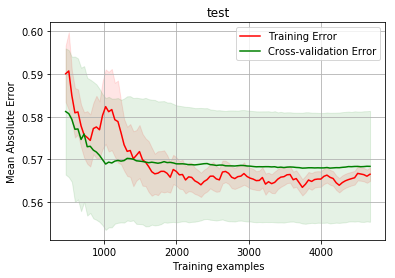

In [19]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_lin_regr(data)
plot_learning_curve(model, "test", train_x, train_y,cv=10)
plt.show()
 

(sk) linear regression Ridge MAE:  0.5488088982267041


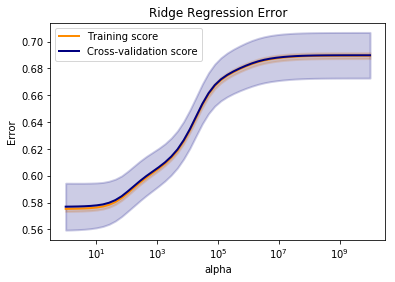

ValueError: x and y can be no greater than 2-D, but have shapes (50,) and (50, 1, 12)

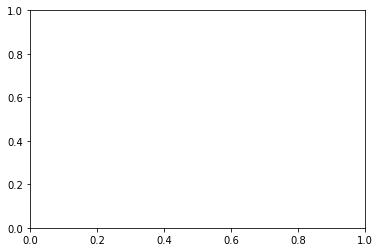

In [28]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_ridge_regr(data,0.1)
plot_validation_curve(model, train_x,train_y,'Ridge Regression Error','neg_mean_absolute_error','alpha',np.logspace(0,10,50))
plt.show()
plot_coef(model,'Ridge Regression Coefficients', train_x,train_y,'alpha',np.logspace(0,10,50))
plt.show()

(sk) linear regression Lasso MAE:  0.6116421845764182


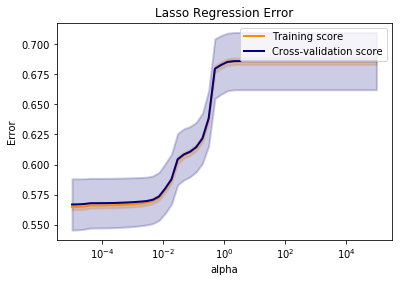

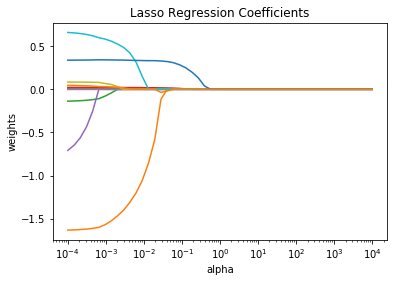

In [29]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
model = sk_lasso_regr(data,0.1)
plot_validation_curve(model, train_x,train_y,'Lasso Regression Error','neg_mean_absolute_error','alpha',np.logspace(-5,5,50))
plt.show()
plot_coef(model,'Lasso Regression Coefficients', train_x,train_y,'alpha',np.logspace(-4,4,50))
plt.show()

(sk) linear regression Elastic Net MAE:  0.560882346651313


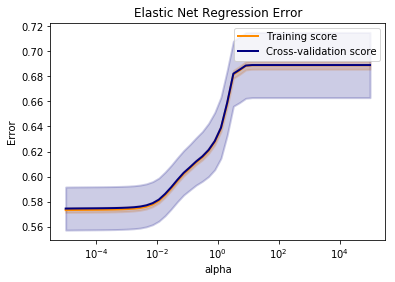

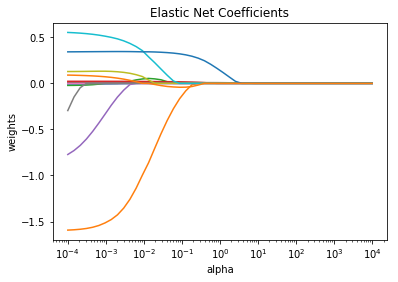

In [30]:
data = get_data(False) 
#df = pd.DataFrame(data)
#print(df)
train_x,train_y,test_x,test_y = split_data(data)
model = sk_elastic_regr(data,0.0001,0.15)
plot_validation_curve(model, train_x,train_y,'Elastic Net Regression Error','neg_mean_absolute_error','alpha',np.logspace(-5,5,50))
plt.show()
plot_coef(model,'Elastic Net Coefficients', train_x,train_y,'alpha',np.logspace(-4,4,50))
plt.show()

(sk) linear regression Elastic Net MAE:  0.5831611475093863


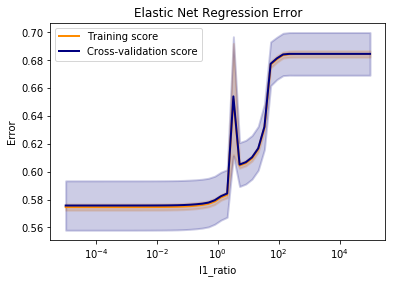

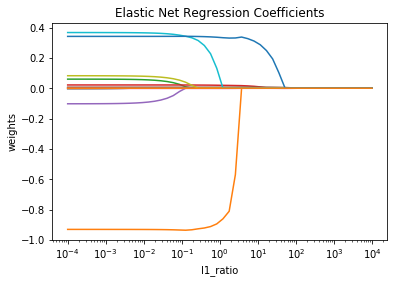

In [31]:
data = get_data(False) 
#df = pd.DataFrame(data)
#print(df)
train_x,train_y,test_x,test_y = split_data(data)
model = sk_elastic_regr(data,0.01,0.01)
plot_validation_curve(model, train_x,train_y,'Elastic Net Regression Error','neg_mean_absolute_error','l1_ratio',np.logspace(-5,5,50))
plt.show()
plot_coef(model,'Elastic Net Regression Coefficients', train_x,train_y,'l1_ratio',np.logspace(-4,4,50))
plt.show()

In [25]:
def bitfield(n):
    return [int(digit) for digit in bin(n)[2:]] 

def search_all_features(data):
    train_x,train_y,test_x,test_y = split_data(data)
    return_list = []
    for i in range(2**12):
        tmp_train_x = train_x
        tmp_test_x  = test_x
        feature_index = bitfield(i)
        tmp = [0 for i in range(NUM_FEATURE-len(feature_index))]
        tmp.extend(feature_index)
        feature_index = tmp
        delete_elements = []
        for j in range(len(feature_index)):
            if(feature_index[j]==0):
                delete_elements.append(j)

        tmp_train_x = np.delete(tmp_train_x,delete_elements,axis=1)
        tmp_test_x  = np.delete(tmp_test_x ,delete_elements,axis=1)
        
        if tmp_train_x!=[]:
            regr = linear_model.LinearRegression() 
            #regr.fit(tmp_train_x,train_y)
            #pred_y = regr.predict(tmp_test_x)
            feature_index.append(cross_validation(tmp_train_x,train_y,regr))
            return_list.append(feature_index)
            #print("(sk) linear regression MAE: ",feature_index)    
    return return_list

In [22]:
data = get_data()
l = search_all_features(data)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [31]:
min_std = [100,0]
max_std = [0,0]
max_mean = [0,0]
min_mean = [100,0]
for i in range(len(l)):
    std  = np.array(l[i][12]).std()
    mean = np.array(l[i][12]).mean()
    if(mean>max_mean[0]):
        max_mean[0] = mean
        max_mean[1] = i
    if(mean<min_mean[0]):
        min_mean[0] = mean
        min_mean[1] = i
    if(std>max_std[0]):
        max_std[0] = std
        max_std[1] = i
    if(std<min_std[0]):
        min_std[0] = std
        min_std[1] = i
print("max_mean: ",np.array(l[max_mean[1]][12]).mean(),np.array(l[max_mean[1]][12]).std(),l[max_mean[1]])
print("min_mean: ",np.array(l[min_mean[1]][12]).mean(),np.array(l[min_mean[1]][12]).std(),l[min_mean[1]])
print("max_std: ",np.array(l[max_std[1]][12]).mean(),np.array(l[max_std[1]][12]).std(),l[max_std[1]])
print("min_std: ",np.array(l[min_std[1]][12]).mean(),np.array(l[min_std[1]][12]).std(),l[min_std[1]])

max_mean:  0.68498326005587 0.02155700377077363 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, [0.6970888415471275, 0.6583689919649711, 0.6854783447721808, 0.7065901229004173, 0.7150886877216291, 0.7159783844835055, 0.6560692887704836, 0.6647227258727095, 0.6784666709549644, 0.6719805415707107]]
min_mean:  0.5688277003307314 0.011358892035836959 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, [0.5749203487892544, 0.5457616493511526, 0.5672363438489776, 0.5841325281900426, 0.5737138771298312, 0.5835496006471678, 0.5581096351028647, 0.5583626557987368, 0.5692933306432213, 0.5731970338060647]]
max_std:  0.638369578683445 0.02692390222358968 [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, [0.6523094190051066, 0.6202259114305602, 0.6213837235494565, 0.6654154382868411, 0.6649693092157015, 0.689481589076765, 0.5990456660041378, 0.6238002322313889, 0.6138745172694281, 0.6331899807650646]]
min_std:  0.5784705511696272 0.008247082269624655 [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, [0.5853634904648838, 0.56735233471572, 0.575301768

## Back Propogation for Hyper-Parameter Tuning

In [204]:
STOP_LIMIT = 2000
def sk_ridge_regr_tuning(data,alpha=0.1):
    #data = normalise(data) 
    train_x,train_y,test_x,test_y = split_data(data)
    regr = linear_model.Ridge(alpha)
    regr.fit(train_x,train_y)
    pred_y = regr.predict(train_x)
   
    #tuning hyperparameter
    lmbda = 10000
    prev_err = cross_validation(train_x,train_y,regr,20)
    print("Previous ERROR: ",prev_err)
    alpha -= alpha/2
    for i in range(STOP_LIMIT):
        regr = linear_model.Ridge(alpha) 
        regr.fit(train_x,train_y)
        curr_err = cross_validation(train_x,train_y,regr,20)
        err_gradient = curr_err - prev_err
        print("Error: ",curr_err,", prev Error: ", prev_err,", Alpha: ",alpha,", gradient: ",err_gradient)
        prev_err = curr_err
        alpha = alpha + lmbda*err_gradient
  
    pred_y = regr.predict(test_x)
    print("(sk) linear regression Ridge MAE: ",mean_absolute_error(test_y,pred_y))
    return regr

In [205]:
data = get_data(False)
train_x,train_y,test_x,test_y = split_data(data)
sk_ridge_regr_tuning(data,100000)

Previous ERROR:  [0.7455309066365557, 0.7087448673184884, 0.7022652813610561, 0.7190603006544816, 0.7332998085431609, 0.7209783895548377, 0.7240912376372641, 0.7174703191307055, 0.735461237031986, 0.7270696091784038, 0.7148263764539379, 0.7559083463486651, 0.6899232828986124, 0.7085055815243709, 0.7217134724113918, 0.6873751341937171, 0.7507276402427172, 0.7130996154834769, 0.7146117301061092, 0.7562476353983367]


TypeError: unsupported operand type(s) for -: 'list' and 'list'

> note, need to deal with large crossvalidation variance

# SVM

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import numpy as np

In [13]:
def cross_validation_svm(train_x,train_y,model_loss,k=10,gamma=0.9,C=1.0):
    #split into K folds
    data = np.concatenate((train_x,train_y),axis=1)
    kf = KFold(n_splits=k)

    error_sum = 0.0
    error = [0 for i in range(k)]
    i=0
    for train,test in kf.split(data):
        train_data  = np.array(data)[train]  
        test_data   = np.array(data)[test]  
        train_x, train_y  = np.hsplit(train_data,[NUM_FEATURE])
        test_x , test_y   = np.hsplit(test_data,[NUM_FEATURE])
        tmp = model_loss(train_x,train_y,test_x,test_y,gamma=gamma,C=C)
        error_sum += tmp
        error[i] = tmp
        i+=1

    #return error_sum/k 
    print(error)
    return error

In [14]:
def plot_validation_curve_svm(model,X,y, title, param_name, param_range):
    
    cross_val_score = []
    for val in param_range:
        if param_name == "gamma":
            cross_val_score.append(cross_validation_svm(X,y,model,gamma=val))
        if param_name == "C":
            cross_val_score.append(cross_validation_svm(X,y,model,C=val))
    
    print(cross_val_score)
    scores_mean = np.mean(cross_val_score, axis=1)
    scores_std = np.std(cross_val_score, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Identity Error")
    #plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, scores_mean, label="Cross Validation Error",
                 color="navy", lw=lw)
    plt.fill_between(param_range, scores_mean - scores_std,
                     scores_mean + scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [15]:
def bin_classify_y(y,val):

    tmp = np.array([[0] for i in range(len(y))])

    for i in range(len(y)):
        if int(y[i][0]) >= val:
            tmp[i][0] =  1
        else:
            tmp[i][0] = -1
    return tmp

In [16]:
def bin_predict_y(y,n):
    if n==1:
        return 0.5*(y[n]+1)
    elif n==9:
        return n + 0.5*(y[n]+1)
    elif y[n]==1 and y[n+1]==-1:
        return n
    elif y[n]==-1 and y[n+1]==1:
        return bin_predict_y(y,n+1)
    elif y[n]==-1 and y[n+1]==-1:
        return bin_predict_y(y,n-1)
    elif y[n]==1 and y[n+1]==1:
        return bin_predict_y(y,n+1)
    else:
        return n

## RBF Kernel

In [13]:
def sk_rbf_SVM(gamma=0.1,C=1.0):
    svm = SVC(kernel="rbf",C=C,gamma=gamma)
    return svm

def sk_rbf_SVM_multi(train_x,train_y,test_x,test_y,gamma=1,C=1.0):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_rbf_SVM(gamma,C) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        #print("N: ", n)
        #for i in range(len(train_y)):
        #    print("y: ",train_y[i],"bin class: ",bin_classify_y(train_y,n)[i],"n: ",n)
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        #print(pred_y[0])
        #print("(sk) SVM level Accuracy: ",(1-identity_loss(bin_classify_y(train_y,n),pred_y)))
        i += 1
    #predict y
    pred_y_raw = [(model.predict(test_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    #for y in pred_y_raw:
    #    print(y)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(12-higher)]) for j in range(len(pred_y_raw))])
    #print(pred_y_raw[0])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    #for i in range(len(pred_y)):
    #for i in range(len(pred_y)):
    #    if pred_y[i] != train_y[i]:
    #        print("predicted value: ",pred_y[i],", actual: ",train_y[i],pred_y_raw[i])
    #print("(sk) SVM level Accuracy: ",(1-identity_loss(train_y,pred_y)))
    return identity_loss(test_y,pred_y)

[0.5461538461538461, 0.5326923076923077, 0.5538461538461539, 0.5423076923076923, 0.5480769230769231, 0.5846153846153846, 0.575, 0.5973025048169557, 0.5703275529865125, 0.5838150289017341]
[0.5, 0.46923076923076923, 0.47884615384615387, 0.4846153846153846, 0.45, 0.49038461538461536, 0.49038461538461536, 0.5394990366088632, 0.47398843930635837, 0.4662813102119461]
[0.4596153846153846, 0.45, 0.4519230769230769, 0.43846153846153846, 0.46153846153846156, 0.4442307692307692, 0.4596153846153846, 0.4951830443159923, 0.4624277456647399, 0.43545279383429675]
[0.41923076923076924, 0.4269230769230769, 0.40192307692307694, 0.40576923076923077, 0.3903846153846154, 0.4, 0.35384615384615387, 0.42196531791907516, 0.4026974951830443, 0.42196531791907516]
[0.4, 0.3903846153846154, 0.37884615384615383, 0.38653846153846155, 0.38076923076923075, 0.3923076923076923, 0.39615384615384613, 0.40655105973025046, 0.394990366088632, 0.43545279383429675]
[0.4096153846153846, 0.3942307692307692, 0.3903846153846154, 0

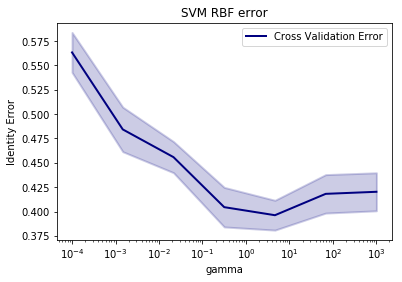

In [14]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_rbf_SVM_multi,train_x,train_y, "SVM RBF error", 'gamma', np.logspace(-4,3,7))
plt.show()

[0.5423076923076923, 0.5980769230769231, 0.573076923076923, 0.5865384615384616, 0.5557692307692308, 0.5826923076923077, 0.5538461538461539, 0.5549132947976878, 0.5549132947976878, 0.558766859344894]
[0.5423076923076923, 0.5980769230769231, 0.573076923076923, 0.5865384615384616, 0.5557692307692308, 0.5826923076923077, 0.5538461538461539, 0.5549132947976878, 0.5549132947976878, 0.558766859344894]
[0.5423076923076923, 0.5980769230769231, 0.573076923076923, 0.5865384615384616, 0.5557692307692308, 0.5826923076923077, 0.5538461538461539, 0.5549132947976878, 0.5549132947976878, 0.558766859344894]
[0.5403846153846154, 0.5903846153846154, 0.5673076923076923, 0.5807692307692308, 0.551923076923077, 0.5788461538461539, 0.551923076923077, 0.5491329479768786, 0.5510597302504817, 0.5568400770712909]
[0.43653846153846154, 0.5, 0.47692307692307695, 0.48846153846153845, 0.47307692307692306, 0.4826923076923077, 0.4461538461538462, 0.4701348747591522, 0.4373795761078998, 0.464354527938343]
[0.392307692307

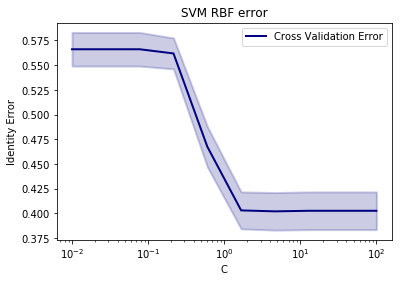

In [46]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_rbf_SVM_multi,train_x,train_y, "SVM RBF error", 'C', np.logspace(-2,2,10))
plt.show()

In [17]:
def sk_lin_SVM(C=0.5,gamma=0.0):
    svm = SVC(kernel="linear",C=C)
    return svm

def sk_lin_SVM_multi(train_x,train_y,test_x,test_y,C=0.5,gamma=0.0):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_lin_SVM(C) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        i += 1
    #predict y
    pred_y_raw = [(model.predict(test_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(11-higher)]) for j in range(len(pred_y_raw))])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    #print("(sk) SVM level Accuracy: ",(1-identity_loss(test_y,pred_y)))
    return identity_loss(test_y,pred_y)

[0.5461538461538461, 0.5326923076923077, 0.5538461538461539, 0.5423076923076923, 0.5480769230769231, 0.5846153846153846, 0.575, 0.5973025048169557, 0.5703275529865125, 0.5838150289017341]
[0.5461538461538461, 0.5326923076923077, 0.5538461538461539, 0.5423076923076923, 0.5480769230769231, 0.5846153846153846, 0.575, 0.5973025048169557, 0.5703275529865125, 0.5838150289017341]
[0.5461538461538461, 0.5326923076923077, 0.5538461538461539, 0.5423076923076923, 0.5480769230769231, 0.5846153846153846, 0.575, 0.5973025048169557, 0.5703275529865125, 0.5838150289017341]
[0.5461538461538461, 0.5326923076923077, 0.5538461538461539, 0.5423076923076923, 0.5480769230769231, 0.5846153846153846, 0.575, 0.5973025048169557, 0.5703275529865125, 0.5838150289017341]
[0.5288461538461539, 0.49038461538461536, 0.5326923076923077, 0.5211538461538462, 0.5211538461538462, 0.5788461538461539, 0.5615384615384615, 0.5664739884393064, 0.5606936416184971, 0.5741811175337187]
[0.5076923076923077, 0.46923076923076923, 0.49

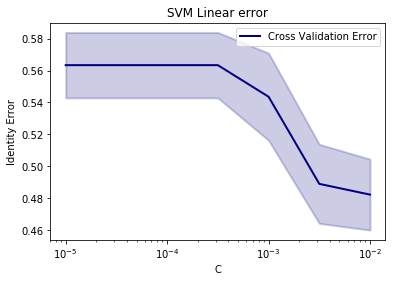

In [18]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_lin_SVM_multi,train_x,train_y, "SVM Linear error", 'C', np.logspace(-5,-2,7))
plt.show()

In [21]:
def sk_sig_SVM(C=1.0,gamma=0.0):
    svm = SVC(kernel="sigmoid",C=C,gamma=gamma)
    return svm

def sk_sig_SVM_multi(train_x,train_y,test_x,test_y,C=2.0,gamma=0.1):
    lower  = 5
    higher = 5
    for y in train_y:
        if y<lower:
            lower = int(y)
        if y>higher:
            higher= int(y)
    models = [sk_sig_SVM(C=C,gamma=gamma) for i in range(lower+1,higher)]
    #fit models
    i = 0
    for n in range(lower+1,higher):
        models[i].fit(train_x,bin_classify_y(train_y,n).ravel())
        i += 1
    #predict y
    pred_y_raw = [(model.predict(test_x)).T for model in models]
    pred_y_raw = np.stack(pred_y_raw,axis=1)
    pred_y_raw = np.array([np.append([1 for i in range(lower+1)],pred_y_raw[j]) for j in range(len(pred_y_raw))])
    pred_y_raw = np.array([np.append(pred_y_raw[j],[-1 for i in range(11-higher)]) for j in range(len(pred_y_raw))])
    pred_y = np.array([bin_predict_y(y,5) for y in pred_y_raw])
    #print("(sk) SVM level Accuracy: ",(1-identity_loss(test_y,pred_y)))
    return identity_loss(test_y,pred_y)

[0.5038461538461538, 0.5134615384615384, 0.5, 0.5384615384615384, 0.47692307692307695, 0.49230769230769234, 0.5038461538461538, 0.5163776493256262, 0.5144508670520231, 0.5163776493256262]
[0.49615384615384617, 0.5057692307692307, 0.49038461538461536, 0.5230769230769231, 0.4480769230769231, 0.48653846153846153, 0.4846153846153846, 0.49903660886319845, 0.5067437379576107, 0.5009633911368016]
[0.4846153846153846, 0.49038461538461536, 0.4807692307692308, 0.5115384615384615, 0.4403846153846154, 0.47307692307692306, 0.4596153846153846, 0.4913294797687861, 0.4913294797687861, 0.4932562620423892]
[0.4846153846153846, 0.47692307692307695, 0.4826923076923077, 0.5019230769230769, 0.4288461538461538, 0.4846153846153846, 0.4576923076923077, 0.48554913294797686, 0.4836223506743738, 0.48554913294797686]
[0.4846153846153846, 0.47115384615384615, 0.4826923076923077, 0.5, 0.4230769230769231, 0.4807692307692308, 0.45, 0.47398843930635837, 0.48747591522157996, 0.47784200385356457]
[0.47692307692307695, 0.

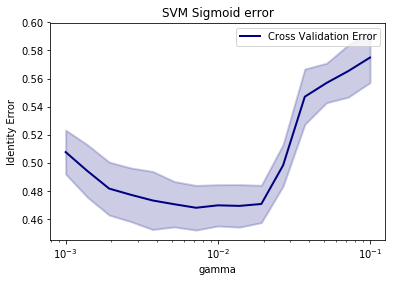

In [22]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_sig_SVM_multi,train_x,train_y, "SVM Sigmoid error", 'gamma', np.logspace(-3,-1,15))
plt.show()

In [251]:
def bin_classify_y(y,val):

    tmp = np.array([[0] for i in range(len(y))])

    for i in range(len(y)):
        if int(y[i][0]) == val:
            tmp[i][0] =  1
        else:
            tmp[i][0] = -1
    return tmp

def bin_predict_y(y,n):
    j = 0
    val = 0
    for i in range(len(y)):
        if y[i]==1:
            val+=i
            j+=1
    if j!=0:
        return int(val/j)
    return 0

In [252]:
data = get_data(False) 
train_x,train_y,test_x,test_y = split_data(data)
plot_validation_curve_svm(sk_rbf_SVM_multi,train_x,train_y, "SVM RBF error", 'C', np.logspace(-2,1,10))
plt.show()

UnboundLocalError: local variable 'pred_y' referenced before assignment

> do for linear, rbf and one other kernel 

> try output classification technique


# Data Analysis

In [32]:
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

NUM_FEATURE = 12

## Correlation Matrix

In [33]:
def normalise(data):
    return (data - data.mean())/data.std()

def normalise_all(data):
    for i in range(NUM_FEATURE):
        data[:,i] = normalise(data[:,i])
    return data

In [34]:
def get_correlation_matrix(data,fig_num):
    data = np.delete(data,-1,axis=1)
    df = pd.DataFrame(data=data)
    fig = plt.figure(fig_num)
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr())
    fig.colorbar(cax)
    return

In [35]:
def visualise_data(x,y,fig_num):
    sz = np.array([0.2 for x in range(len(y))])
    fig = plt.figure(fig_num)
    for i in range(NUM_FEATURE):
        ax = fig.add_subplot(2,6,i+1)
        x_norm = normalise(x[:,i])
        ax.scatter(x_norm,y,sz)
        ax.set_ylim([0,10])
        ax.set_xlim(xmin=0)

    return

In [36]:
def get_data_plot(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])
    visualise_data(x,y,fig_num)
    return

In [37]:
def get_corr_coef(x,y):
    coef_array = np.corrcoef(np.transpose(x),np.transpose(y))
    return coef_array[0,1]


def get_data_output_correlation_plot(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])
    x = normalise_all(x)
    corr = np.array([get_corr_coef(x[:,i],y) for i in range(NUM_FEATURE)])
    x_axis = np.arange(NUM_FEATURE)

    plt.figure(fig_num)
    plt.bar(x_axis,corr)
    return

In [38]:
def get_output_dist(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])

    fig = plt.figure(fig_num)
    sns.distplot(np.transpose(y))

    return

def get_feature_dist(data,fig_num):
    data = np.delete(data,(0),axis=0)
    x,y = np.hsplit(data,[NUM_FEATURE])

    x = normalise_all(x)

    fig = plt.figure(fig_num)

    for i in range(NUM_FEATURE):
        ax = fig.add_subplot(2,6,i+1)
        sns.distplot(np.transpose(x[:,i]))

    return

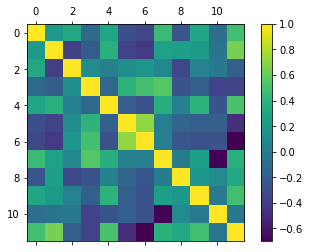

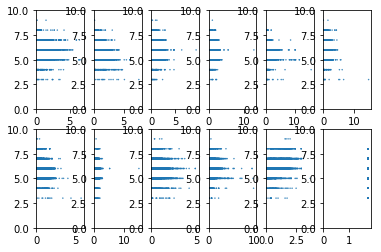

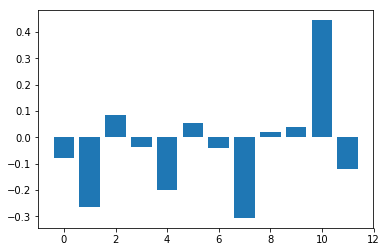

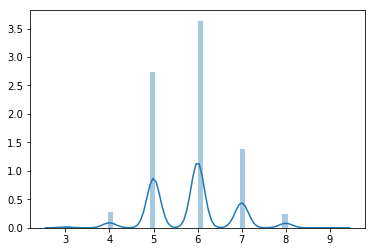

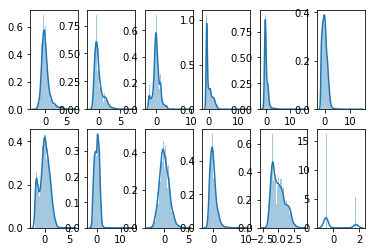

In [39]:
data = get_data()
get_correlation_matrix(data,1)
get_data_plot(data,2)
get_data_output_correlation_plot(data,3)
get_output_dist(data,4)  
get_feature_dist(data,5)

# TODO
 -  sort out classification problem (one vs all, and decide on boundaries)
 -  explore what C term means
 -  try different SVM kernels
 -  justify SVM choice
 -  equations for everything
 -  justify loss functions
 -  Appendix for Data Analysis
 -  outlier removal (justify with results without it)
 -  gradient descent on parameters (optional)